<a href="https://colab.research.google.com/github/amanrana21711/Liver_UF/blob/main/Liver_UF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/liver_cirrhosis.csv')
data['Status'] = data['Status'].map({'C': 0,'CL':1,'D':2})
data['Drug'] = data['Drug'].map({'Placebo': 0,'D-penicillamine':1})
data['Sex'] = data['Sex'].map({'M': 0,'F':1})
data['Ascites'] = data['Ascites'].map({'N': 0,'Y':1})
data['Hepatomegaly'] = data['Hepatomegaly'].map({'N': 0,'Y':1})
data['Spiders'] = data['Spiders'].map({'N': 0,'Y':1})
data['Edema'] = data['Edema'].map({'N': 0,'S':1,'Y':2})
data['Stage'] = data['Stage'].map({1: 0,2:1, 3:2})

inputs = data.drop('Stage',axis = 1).values
outputs = data['Stage'].values



# Converted the data so they can be made tensors


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(inputs,outputs,test_size = 0.2, shuffle = True)


x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

tensor_ds = TensorDataset(x_train,y_train)
tensor_dl = DataLoader(tensor_ds, batch_size = 15,shuffle = True)

val_tensor_ds = TensorDataset(x_test,y_test)
val_tensor_dl = DataLoader(val_tensor_ds,batch_size = 15, shuffle = True)



In [5]:
class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(18,36)
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(36,72)
    self.act2 = nn.ReLU()
    self.linear3 = nn.Linear(72,3)
  def forward(self,x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    return x

model = NN()

loss_fun = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr = 0.0001)


scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 5)

ell = []
ll = []
epochl = []
al = []


In [6]:
for epoch in range(1000):
  vl = 0
  lc = 0
  for xb,yb in tensor_dl:

    preds = model(xb)

    loss = loss_fun(preds,yb)

    loss.backward()

    opt.step()
    opt.zero_grad()

    lc += loss.item()

  total = 0
  correct = 0
  for xx, yy in val_tensor_dl:
    predictions = model(xx)
    val_loss = loss_fun(predictions,yy)
    vl += val_loss.item()
    total += len(yy)
    predicted = torch.argmax(predictions,dim=1)


    correct += (predicted == yy).sum().item()


  acc = 100*correct/float(total)

  if epoch%100 ==99:
    print(f"At Epoch: {epoch} Loss is ->{loss.item()}")
    ll.append(loss.item())
    epochl.append(epoch)

    # accuracy
    print(f'At Epoch: {epoch} Accuracy is -> {acc}')






At Epoch: 99 Loss is ->0.15132273733615875
At Epoch: 99 Accuracy is -> 85.26
At Epoch: 199 Loss is ->0.33841031789779663
At Epoch: 199 Accuracy is -> 87.58
At Epoch: 299 Loss is ->0.036121759563684464
At Epoch: 299 Accuracy is -> 88.56
At Epoch: 399 Loss is ->0.023750441148877144
At Epoch: 399 Accuracy is -> 89.0
At Epoch: 499 Loss is ->0.33288151025772095
At Epoch: 499 Accuracy is -> 89.32
At Epoch: 599 Loss is ->0.09247972071170807
At Epoch: 599 Accuracy is -> 89.72
At Epoch: 699 Loss is ->0.022426113486289978
At Epoch: 699 Accuracy is -> 89.56
At Epoch: 799 Loss is ->0.04774948209524155
At Epoch: 799 Accuracy is -> 89.82
At Epoch: 899 Loss is ->0.22234900295734406
At Epoch: 899 Accuracy is -> 89.96
At Epoch: 999 Loss is ->0.25389987230300903
At Epoch: 999 Accuracy is -> 90.08


141.05405957298353

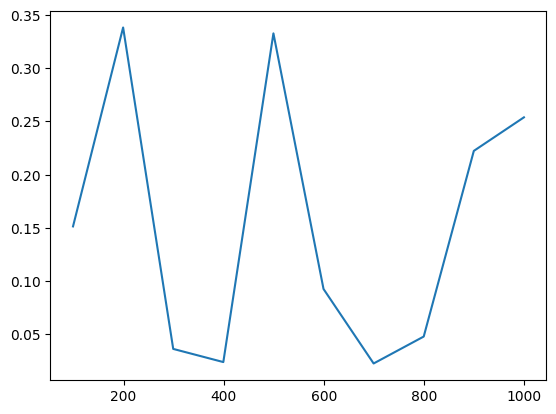

In [9]:
import matplotlib.pyplot as plt

plt.plot(epochl,ll)


In [11]:
preds_new = model(x_test)
to = torch.argmax(preds_new,dim=1)

correct = 0
incorrect = 0

for i in range(len(preds_new)):
  if to[i] == y_test[i]:
    correct += 1
  else:
    incorrect += 1

print(correct,incorrect,incorrect+correct)


4504 496 5000
